<a href="https://colab.research.google.com/github/rho-selynn/592-HW3/blob/Michael/592_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



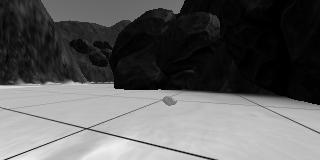

(1000, 160, 320)


In [22]:
import cv2 
import os 
import glob 
from google.colab.patches import cv2_imshow
import numpy as np
import torch
img_dir = "Images"
data_path = os.path.join(img_dir,'*g') 
files = glob.glob(data_path) 
Images = [] 
for f1 in files: 
    img = cv2.imread(f1, 0) 
    Images.append(img)
Images = np.array(Images)
cv2_imshow(Images[0])
print(np.shape(Images))
Images = (np.divide(Images, 255))
Images = Images.astype(float)

In [29]:
controlData = np.loadtxt('robot_log.csv', delimiter = ';', skiprows = 1, usecols = (1,2,3))
controlData = controlData.astype(float)
print(controlData)

[[0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [30]:
from torch.utils.data import TensorDataset
ImagesTrain = torch.tensor(Images[0:800])
steerDataTrain = torch.tensor(controlData[0:800, 0])
trainSteerDataset = TensorDataset(ImagesTrain, steerDataTrain)
ImagesTest = torch.tensor(Images[801:999])
steerDataTest = torch.tensor(controlData[801:999, 0])
testSteerDataset = TensorDataset(ImagesTest, steerDataTest)
throttleDataTrain = torch.tensor(controlData[0:800, 1])
trainThrottleDataset = TensorDataset(ImagesTrain, throttleDataTrain)
throttleDataTest = torch.tensor(controlData[801:999, 1])
testThrottleDataset = TensorDataset(ImagesTest, throttleDataTest)

In [31]:
steerTrainDataLoader = torch.utils.data.DataLoader(trainSteerDataset, batch_size=64, shuffle=True)
steerTestDataLoader = torch.utils.data.DataLoader(testSteerDataset, batch_size=64, shuffle=False)
throttleTrainDataLoader = torch.utils.data.DataLoader(trainThrottleDataset, batch_size=64, shuffle=True)
throttleTestDataLoader = torch.utils.data.DataLoader(testThrottleDataset, batch_size=64, shuffle=False)

In [32]:
class LR(torch.nn.Module):
    def __init__(self):
        super(LR, self).__init__()
        self.linear1 = torch.nn.Linear(160*320, 128) # W:784x128 , b:128x1 , parameters = [W,b]
        self.linear2 = torch.nn.Linear(128, 10)
    
    def forward(self, x):
        x = x.view(-1,160*320)
        transformed_x1 = self.linear1(x)
        transformed_x2 = self.linear2(transformed_x1)
        return transformed_x2
net = LR()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

In [33]:
train_loss_history = []
test_loss_history = []
net = net.float()
for epoch in range(5):
    train_loss = 0.0
    test_loss = 0.0
    for i, data in enumerate(steerTrainDataLoader):
        images, labels = data
        #images = images.cuda()
        #labels = labels.cuda()
        optimizer.zero_grad()
        predicted_output = net(images)
        loss = criterion(predicted_output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    for i, data in enumerate(steerTestDataLoader):
        with torch.no_grad():
            images, labels = data
            #images = images.cuda()
            #labels = labels.cuda()
            predicted_output = net(images)
            loss = criterion(predicted_output, labels)
            test_loss += loss.item()
    train_loss = train_loss/len(steerTrainDataLoader)
    test_loss = test_loss/len(steerTestDataLoader)
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    print('Epoch %s finished with train loss %s and test loss %s'%(epoch, train_loss, test_loss))

RuntimeError: ignored